# Exploring Feature Importance and Feature Interaction

This notebook explores ideas around Feature Importance and Feature Interaction by generating a synthetic data set with fetures of different feature importance and interactivity. Its purpose is to validate using methods of feature importance and to explore methods of discovering features which have strong interaction with other features.

A lot of these ideas come from the excellent 'fastai' course 'Introduction to Machine Learning for Coders' http://course18.fast.ai/ml

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import math

First create features from different random distributions. Features were designed to be roughly normalised with a range of [-1, 1]. Different distributions were used to see if this had an effect on feature importance.

In [2]:
n_samples = 10000

In [3]:
x1 = np.random.normal(0, 0.4, n_samples)
x2 = np.random.normal(0.02, 0.37, n_samples)
x3 = np.random.normal(0, 0.2, n_samples)
x4 = np.random.normal(0, 0.3, n_samples)
x5 = np.random.normal(-1, 0.5, n_samples)
x6 = np.random.lognormal(-1, 0.3, n_samples)
x7 = np.random.lognormal(0, 0.4, n_samples) - 1.5
x8 = np.random.uniform(-1, 1, n_samples)
x9 = np.random.uniform(-1, 1, n_samples)
x10 = np.random.uniform(-1, 1, n_samples)

Example of a Normally distributed feature

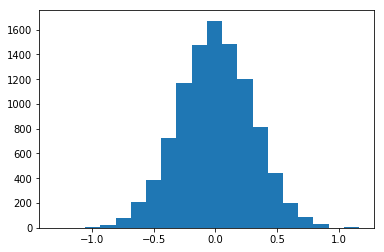

In [4]:
plt.hist(x4, bins=20)
plt.show()

Example of a log normal distributed feature

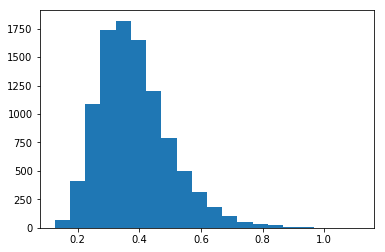

In [7]:
plt.hist(x6, bins=20)
plt.show()

uniform dist

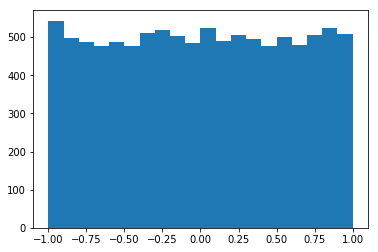

In [8]:
plt.hist(x10, bins=20)
plt.show()

Now we create our independent variable 'y'. 

In [9]:
# Start with our strongest feature we want to see if we can find later x2-x1
y = 10*(x2-x1)

# give x1 a small amount of influence also on prediction
y -= x1

# give x2 a moderate amount of influence also on prediction
y += 3*x2

# give x3 the largest amount of singular prediction from any 1 variable
y += 6*x3

# give x4 the least (but not no) amount of prediction
y += 0.2*x4

# give x5 a small amount of prediction
y -= 2*x5

# give varying amounts for all other variables
y += 4.5*x6
y -= 3*x7
y += 0.7*x8
y -= 2*x9
# x10 has no effect on y - redundant code below
y += 0*x10 

# Add one more weak correlation interaction
y -= 5*(x4-x9)

# Add a bias
y += 32.5

# Add some random noise
y += np.random.normal(0, 1, y.shape)

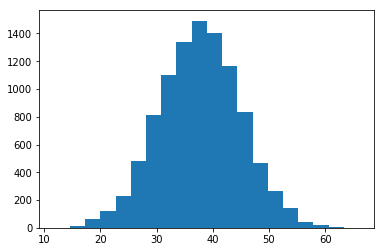

In [10]:
plt.hist(y, bins=20)
plt.show()

In [11]:
y.min(), y.max()

(11.860622205436069, 66.031583634922569)

stack all of our independent variables x1, x2, ..., x10 into a pd data frame. So that we can input them into our model

In [12]:
x = {'x1': x1, 'x2': x2, 'x3': x3, 'x4': x4, 'x5': x5,
     'x6': x6, 'x7': x7, 'x8': x8, 'x9': x9, 'x10': x10}

x = pd.DataFrame(x)

In [13]:
x.head()

,x1,x10,x2,x3,x4,x5,x6,x7,x8,x9
0,0.532482,0.347127,0.317259,0.065466,-0.117849,-0.604571,0.287845,-0.822977,-0.935876,-0.297105
1,0.154413,-0.148272,-0.133689,-0.066263,0.051687,-0.898894,0.510545,-0.755187,0.084769,0.556772
2,0.628971,-0.365965,-0.003474,-0.159917,0.491379,-1.442894,0.357030,-0.191587,0.773838,0.464215
3,0.000993,-0.279301,-0.084702,-0.036669,-0.335837,-1.354750,0.443948,-0.561084,-0.344081,0.704657
4,-0.061437,-0.968624,-0.263371,0.096336,-0.451949,-0.665477,0.367038,0.001144,0.472466,-0.899134


In [14]:
x.shape

(10000, 10)

Split dataset and labels into train, validate and test

In [15]:
x_trn, x_val, x_test = x.iloc[:8000, :], x.iloc[8000:9000, :], x.iloc[9000:, :]
y_trn, y_val, y_test = y[:8000], y[8000:9000], y[9000:]

In [16]:
x_trn.shape, x_val.shape, x_test.shape

((8000, 10), (1000, 10), (1000, 10))

In [17]:
y_trn.shape, y_val.shape, y_test.shape

((8000,), (1000,), (1000,))

Train a model

In [18]:
m = RandomForestRegressor(n_estimators=50).fit(x_trn, y_trn)

Score and evaluate the model

In [35]:
def rmse(x,y): 
    return math.sqrt(((x-y)**2).mean())

def print_score(m, pass_back=False):
    res = [rmse(m.predict(x_trn), y_trn), rmse(m.predict(x_val), y_val),
                m.score(x_trn, y_trn), m.score(x_val, y_val)]
    print(f'Train RMSE: {round(res[0], 3)}')
    print(f'Validation RMSE: {round(res[1], 3)}')
    print(f'Train R-Squared: {round(res[2], 3)}')
    print(f'Validation R-Squared: {round(res[3], 3)}')
    if pass_back:
        return res

In [36]:
scores = print_score(m, pass_back=True)
val_rmse = scores[1]

Train RMSE: 0.739
Validation RMSE: 1.928
Train R-Squared: 0.99
Validation R-Squared: 0.927


Plot labels of training data vs predictions of training data

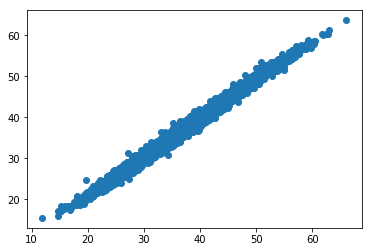

In [28]:
plt.scatter(y_trn, m.predict(x_trn))
plt.show()

Plot predictions of validation data vs true labels

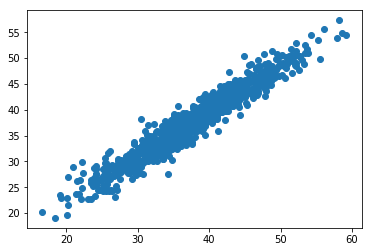

In [30]:
plt.scatter(y_val, m.predict(x_val))
plt.show()

Evaluate Feature importance - Go through the inputs to the model one at a time and shuffle the values of one column. Make predictions using the data with one row shuffled. Evaluate the effect on the models score rank each feature by how much the models score was negatively effected when removed 

* re-write above

In [31]:
df_importance = pd.DataFrame()
for col in x_val.columns:
    x_shuffle = x_val.copy()
    shuffled_column = x_shuffle[col].values
    np.random.shuffle(shuffled_column)
    x_shuffle[col] = shuffled_column
    rmse_score = rmse(y_val, m.predict(x_shuffle))
    row = {}
    row['col'] = col
    row['score'] = rmse_score
    df_importance = df_importance.append(row, ignore_index=True)

df_importance = df_importance.sort_values(by='score')

In [37]:
top_ten_fi_vars = df_importance.reset_index(drop=True).iloc[:10, 0].values

df_importance['error_diff'] = val_rmse - df_importance['score']

error_diffs = {row['col']: row['error_diff'] for i, row in df_importance.iterrows()}

df_importance = df_importance.sort_values(by='error_diff', ascending=True)
df_importance.head(10)

,col,score,error_diff
2,x2,7.270263,-5.342464
0,x1,6.179721,-4.251922
9,x9,2.904588,-0.976789
4,x4,2.504639,-0.576841
7,x7,2.425217,-0.497418
3,x3,2.236980,-0.309182
5,x5,2.095777,-0.167978
6,x6,1.963741,-0.035942
8,x8,1.954908,-0.027110
1,x10,1.932039,-0.004240
